<a href="https://colab.research.google.com/github/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex/blob/main/Illustration_decoding_methodologies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----------------------------------------------------------------------------
# Generating illustration figures
-----------------------------------------------------------------------------

-----------------------------------------------------------------------------
## Private key
For the notebook to download the data from the Figshare repository prior to acceptance of the manuscript you need to insert the private link token mentioned in the "Code availability" section of the manuscript.

In [ ]:

private_link = input('Enter the private link token:')

# First, download data and import toolboxes

In [2]:
import os, re, pickle, warnings, time
from pathlib import Path
from itertools import combinations
import sys
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests
from pathlib import PurePath
from scipy.stats import gaussian_kde
import jax.numpy as jnp
from jax import jit
# Determine the path to the repository based on the environment
IN_COLAB = False
IN_KAGGLE = False # Assuming not in Kaggle for now
try:
    if 'google.colab' in str(get_ipython()):
        IN_COLAB = True
except NameError:
    pass

if IN_COLAB:
    path_to_repo = '/content/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
elif IN_KAGGLE:
    path_to_repo = '/kaggle/working/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
else:
    # Assume local environment where the .py file is in the root of the repo
    path_to_repo = '.'

# Only clone if not already present
if not os.path.exists(path_to_repo):
    os.system("git clone https://github.com/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex.git " + path_to_repo)

sys.path.append(path_to_repo)
sys.path.append(os.path.join(path_to_repo, 'utils'))

from extract_and_download_data import download_files, unzip
from image_processing import m_pathway_filter_gaussian

FIG_DIR = Path("Figures") # Convert to Path object
os.makedirs(FIG_DIR, exist_ok=True)
CACHE_DIR = Path(".cache");   CACHE_DIR.mkdir(exist_ok=True) # From Category decoding

# Define the directory where files are downloaded
DOWNLOAD_DIR = Path("downloads") # Convert to Path object
os.makedirs(DOWNLOAD_DIR, exist_ok=True)


# -------------------------------------------------------------------
# Download required data files once (using the new method)
files_to_download = ["hvm_public_extended_meta.csv",
    "background_variations_images.zip",
    "high_variation_stimuli.zip",
]
# Pass the correct path to file_code_mapping.csv to download_files
download_success = download_files(path_to_repo, files_to_download, private_link=private_link)

meta_downloaded_path = DOWNLOAD_DIR / "hvm_public_extended_meta.csv" # Use Path object
dnn_zip_downloaded_path = DOWNLOAD_DIR / "deepNetFeatures.zip" # Use Path object
even_downloaded_path = DOWNLOAD_DIR / "Spike_count_even_sessions.npy" # Use Path object
odd_downloaded_path = DOWNLOAD_DIR / "Spike_count_odd_sessions.npy" # Use Path object


meta_downloaded = meta_downloaded_path.exists()
dnn_zip_downloaded = dnn_zip_downloaded_path.exists()
even_downloaded_check = even_downloaded_path.exists()
odd_downloaded_check = odd_downloaded_path.exists()


if not (meta_downloaded and dnn_zip_downloaded):
    print("Failed to download necessary files. Exiting.")
    # exit() # Do not exit, just skip the parts that require these files

if dnn_zip_downloaded:
    # Update unzip to use the downloaded zip path and specify the extraction directory
    unzip(dnn_zip_downloaded_path, "deepNetFeatures")

Successfully downloaded downloads/hvm_public_extended_meta.csv.
Successfully downloaded downloads/background_variations_images.zip.
Successfully downloaded downloads/high_variation_stimuli.zip.
Failed to download necessary files. Exiting.


# Category-abstract position decoding

In [3]:
def load_and_align(pkl_path, meta_df):
    with open(pkl_path, "rb") as fh:
        d = pickle.load(fh)
    X = d["penultimate"]
    if X.ndim > 2:
        X = X.reshape(X.shape[0], -1)
    names = [Path(n).stem for n in d["image_names"]]
    idx = [names.index(b) for b in meta_df["base"]]
    return X[idx].astype(np.float64)

def predict_angles(net, pkl_path, meta_df, y_target, categories):
    X = load_and_align(pkl_path, meta_df)
    pred_t = np.zeros_like(y_target, dtype=np.float64)
    for cat in categories:
        tr = meta_df["category_name"] != cat
        te = ~tr
        pca = PCA(n_components=50, random_state=42)
        Xtr = pca.fit_transform(X[tr])
        Xte = pca.transform(X[te])
        reg = LinearRegression().fit(Xtr, y_target[tr])
        pred_t[te] = reg.predict(Xte)
    return np.arctan2(pred_t[:, 1], pred_t[:, 0])

def circ_diff(a, b):
    return np.arctan2(np.sin(a - b), np.cos(a - b))

def perm_pvalue(empirical, null_samples):
    if null_samples is None or len(null_samples) == 0 or np.isnan(empirical):
        return np.nan
    return (np.sum(null_samples <= empirical) + 1) / (len(null_samples) + 1)

def p_to_stars(p):
    if np.isnan(p):  return ''
    if p < 1e-4:     return '****'
    if p < 1e-3:     return '***'
    if p < 1e-2:     return '**'
    if p < 5e-2:     return '*'
    return ''

# ───────────────────────── Quarter‑circle drawing ─────────────────────────
THETA_MAX_DEG = 95   # extend slightly beyond 90° to include left KDE tail
THETA_MAX     = np.deg2rad(THETA_MAX_DEG)

def _deg_label(ax, R, deg):
    th = np.deg2rad(deg)
    ax.text(R*1.08*np.cos(th), R*1.08*np.sin(th), f'{deg}°',
            ha='center', va='center', fontsize=10, zorder=5)

def quartercircle_axes(ax, R=1.0, theta_max=THETA_MAX):
    """Draw only a quarter of a circle (0° → ~95°) with degree labels."""
    t = np.linspace(0, theta_max, 300)
    ax.plot(R*np.cos(t), R*np.sin(t), lw=1.2, color='black', zorder=2)

    # Degree labels around the arc
    for deg in (0, 30, 60, 90):
        _deg_label(ax, R, deg)

    # Neat framing for the first quadrant
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-R*0.05, R*1.25)
    ax.set_ylim(-R*0.05, R*1.55)
    ax.axis('off')

def draw_kde_bump(ax, samples, *,
                  R=1.0, height=0.35, n=400, color="black",
                  alpha_fill=0.22, lw=2.0, z=3, theta_max=THETA_MAX):
    """
    Draw a KDE "bump" outside the quarter arc.
    Samples are cropped to 1–99 percentiles to avoid extreme tails.
    Evaluated only on [0, theta_max] (default 95°).
    """
    samples = np.asarray(samples).ravel()
    if samples.size < 2 or not np.all(np.isfinite(samples)):
        return

    lo, hi = np.percentile(samples, [1, 99])
    samples = samples[(samples >= lo) & (samples <= hi)]
    if samples.size < 2:
        return

    try:
        kde = gaussian_kde(samples)
    except np.linalg.LinAlgError:
        if np.allclose(samples, samples[0]):
            theta = float(samples[0])
            theta = np.clip(theta, 0.0, theta_max)
            xb, yb = R*np.cos(theta), R*np.sin(theta)
            xd, yd = (R+height)*np.cos(theta), (R+height)*np.sin(theta)
            ax.plot([xb, xd], [yb, yd], color=color, lw=lw, zorder=z)
        return

    thetas = np.linspace(0.0, theta_max, n)  # evaluate only over the quarter
    dens = kde(thetas)
    if dens.max() == 0:
        return
    dens /= np.max(dens)

    f = height * dens
    xb, yb = R*np.cos(thetas),     R*np.sin(thetas)
    xd, yd = (R+f)*np.cos(thetas), (R+f)*np.sin(thetas)

    ax.fill_between(xb, yb, yd, color=color, alpha=alpha_fill, zorder=z)
    ax.plot(xd, yd, color=color, lw=lw, zorder=z+1)

# ───────────────────────── Config (unchanged) ─────────────────────────
plt.rcParams.update({"svg.fonttype": "none"})  # keep text editable in SVG
NEURAL_COLOR = (0.3372549, 0.70588235, 0.91372549)  # BLUE
DNN_COLOR    = (0.0, 0.0, 0.0)                        # BLACK

FIG_DIR = Path(globals().get("FIG_DIR", "Figures")); FIG_DIR.mkdir(exist_ok=True)
meta_downloaded_path = globals().get("meta_downloaded_path", "downloads/hvm_public_extended_meta.csv")
even_downloaded_path = globals().get("even_downloaded_path", "downloads/Spike_count_even_sessions.npy")
odd_downloaded_path  = globals().get("odd_downloaded_path",  "downloads/Spike_count_odd_sessions.npy")
dnn_zip_downloaded   = globals().get("dnn_zip_downloaded", True)

even_downloaded_check = Path(even_downloaded_path).exists()
odd_downloaded_check  = Path(odd_downloaded_path).exists()

# ───────────────────────── Data prep (unchanged) ─────────────────────────
meta = pd.read_csv(meta_downloaded_path)
meta["base"] = meta["filename"].str.replace(r"\.\w+$", "", regex=True)

# keep only the 2,560 high-variation stimuli (skip first 640)
valid_idx = np.arange(640, len(meta))
meta = meta.iloc[valid_idx].reset_index(drop=True)

# centroid → polar angle (y, x)
pos = np.vstack((meta["centroid_y"].values, meta["centroid_x"].values)).T
pos = (pos - 128) / 256 * 8
true_angle = np.arctan2(pos[:, 1], pos[:, 0])  # note: (y, x) swap preserved
y_target = np.column_stack((np.cos(true_angle), np.sin(true_angle)))

categories   = meta["category_name"].unique()
cat_labels   = meta["category_name"].values
_cat_to_idx  = {c: np.flatnonzero(cat_labels == c) for c in categories}

# ───────────────────── Neural decoding (Early) (unchanged) ─────────────────────
if even_downloaded_check and odd_downloaded_check:
    rate_even = np.load(even_downloaded_path, allow_pickle=True)
    rate_odd  = np.load(odd_downloaded_path,  allow_pickle=True)
    rate = ((rate_even + rate_odd) / 2.0)[valid_idx]  # align to meta

    time_range_early = slice(5, 9)  # 50–90 ms
    feats = rate[:, :, time_range_early].reshape(rate.shape[0], -1)

    pred_target = np.zeros_like(y_target)
    for cat in categories:
        tr = meta["category_name"] != cat
        te = ~tr
        pca = PCA(n_components=50, random_state=42)
        Xtr = pca.fit_transform(feats[tr])
        Xte = pca.transform(feats[te])
        reg = LinearRegression().fit(Xtr, y_target[tr])
        pred_target[te] = reg.predict(Xte)

    pred_ang = np.arctan2(pred_target[:, 1], pred_target[:, 0])
    angle_diff_early = circ_diff(pred_ang, true_angle)

    N_PERM = 10_000
    mae_neural = {"Early": np.abs(angle_diff_early).mean()}
    mae_perm_neural = {"Early": np.empty(N_PERM, dtype=np.float64)}

    rng = np.random.default_rng(42)
    for i in range(N_PERM):
        shuffled = true_angle.copy()
        for _, idxs in _cat_to_idx.items():
            shuffled[idxs] = rng.permutation(shuffled[idxs])
        diff_p = circ_diff(pred_ang, shuffled)
        mae_perm_neural["Early"][i] = np.abs(diff_p).mean()
else:
    print("Skipping neural decoding (even/odd data not available).")
    N_PERM = 10_000
    mae_neural = {"Early": np.nan}
    mae_perm_neural = {"Early": np.array([], dtype=np.float64)}

# ───────────────────── Low‑pass DNN decoding (pooled) (unchanged) ─────────────────────
if dnn_zip_downloaded:
    feature_dir = Path("deepNetFeatures")
    p = re.compile(r"^(?P<net>.*?)_features_high_variation_lowpass\.pkl$")
    feat_files = [(m.group("net"), f) for f in feature_dir.glob("*.pkl") if (m := p.match(f.name))]

    if len(feat_files) == 0:
        print("No low-pass DNN feature files found.")
        perm_mae_dnn = np.array([]); mae_dnn = np.nan; err_per_trial = np.array([])
    else:
        pred_angles_all = Parallel(n_jobs=-1, backend="loky")(
            delayed(predict_angles)(n, f, meta, y_target, categories)
            for n, f in feat_files
        )
        pred_angles_all = np.vstack(pred_angles_all)  # n_nets × n_trials
        avg_cos = np.cos(pred_angles_all).mean(axis=0)
        avg_sin = np.sin(pred_angles_all).mean(axis=0)
        avg_pred_angle = np.arctan2(avg_sin, avg_cos)

        err_per_trial = np.abs(circ_diff(avg_pred_angle, true_angle))
        np.save("mean_pos_error_per_trial.npy", err_per_trial)

        mae_dnn = err_per_trial.mean()

        perm_mae_dnn = np.empty(N_PERM, dtype=np.float64)
        rng = np.random.default_rng(123)
        for i in range(N_PERM):
            shuffled = true_angle.copy()
            for _, idxs in _cat_to_idx.items():
                shuffled[idxs] = rng.permutation(shuffled[idxs])
            diff_p = circ_diff(avg_pred_angle, shuffled)
            perm_mae_dnn[i] = np.abs(diff_p).mean()
else:
    print("Skipping DNN decoding (zip not available).")
    perm_mae_dnn = np.array([]); mae_dnn = np.nan; err_per_trial = np.array([])

# ───────────────────── Stats (unchanged) ─────────────────────
p_neural = perm_pvalue(mae_neural.get("Early", np.nan), mae_perm_neural.get("Early", np.array([])))
p_dnn    = perm_pvalue(mae_dnn, perm_mae_dnn)

# ───────────────────── Plot (quarter‑circle up to 95°) ─────────────────────
have_neural = (len(mae_perm_neural["Early"]) > 0) and (not np.isnan(mae_neural.get("Early", np.nan)))
have_dnn    = (perm_mae_dnn.size > 0) and (not np.isnan(mae_dnn))

if have_neural or have_dnn:
    fig, ax = plt.subplots(1, 1, figsize=(7.0, 5.6), constrained_layout=True)
    quartercircle_axes(ax, R=1.0, theta_max=THETA_MAX)

    # KDE bumps — DNN: black, NEURAL: blue
    if have_dnn:
        draw_kde_bump(ax, perm_mae_dnn, R=1.0, height=0.34,
                      color="black", alpha_fill=0.18, lw=2.2, z=3, theta_max=THETA_MAX)
    if have_neural:
        draw_kde_bump(ax, mae_perm_neural["Early"], R=1.0, height=0.38,
                      color=NEURAL_COLOR, alpha_fill=0.26, lw=2.2, z=4, theta_max=THETA_MAX)

    # Observed MAE rays — clip angle to 95° so arrows stay inside the panel
    eps = np.deg2rad(0.25)
    if have_dnn:
        thD = np.clip(mae_dnn, 0.0, THETA_MAX - eps)
        ax.annotate("", xy=((1.0 + 0.30) * np.cos(thD), (1.0 + 0.30) * np.sin(thD)),
                    xytext=(0, 0),
                    arrowprops=dict(arrowstyle='-|>', lw=2.6, color=DNN_COLOR),
                    zorder=6)
        s = p_to_stars(p_dnn)
        if s:
            ax.text((1.0 + 0.33) * np.cos(thD), (1.0 + 0.33) * np.sin(thD),
                    s, ha='center', va='center', fontsize=12, color=DNN_COLOR, zorder=7)

    if have_neural:
        thN = np.clip(mae_neural["Early"], 0.0, THETA_MAX - eps)
        ax.annotate("", xy=((1.0 + 0.30) * np.cos(thN), (1.0 + 0.30) * np.sin(thN)),
                    xytext=(0, 0),
                    arrowprops=dict(arrowstyle='-|>', lw=2.6, color=NEURAL_COLOR),
                    zorder=6)
        s = p_to_stars(p_neural)
        if s:
            ax.text((1.0 + 0.33) * np.cos(thN), (1.0 + 0.33) * np.sin(thN),
                    s, ha='center', va='center', fontsize=12, color=NEURAL_COLOR, zorder=7)

    ax.set_title("Object Position Decoding (MAE, 0°–95°)", pad=10, fontsize=13)

    out_png = FIG_DIR / "objpos_decoding_quartercircle_deg.png"
    out_svg = FIG_DIR / "objpos_decoding_quartercircle_deg.svg"
    out_pdf = FIG_DIR / "objpos_decoding_quartercircle_deg.pdf"
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    fig.savefig(out_svg, bbox_inches="tight")
    fig.savefig(out_pdf, bbox_inches="tight")
    plt.show()
    print(f"Figure saved → {out_png}\n                 {out_svg}\n                 {out_pdf}")
else:
    print("Skipping plot: no permutation data available.")

Skipping neural decoding (even/odd data not available).
Skipping DNN decoding (zip not available).
Skipping plot: no permutation data available.


## Illustration of decoding crossvalidation

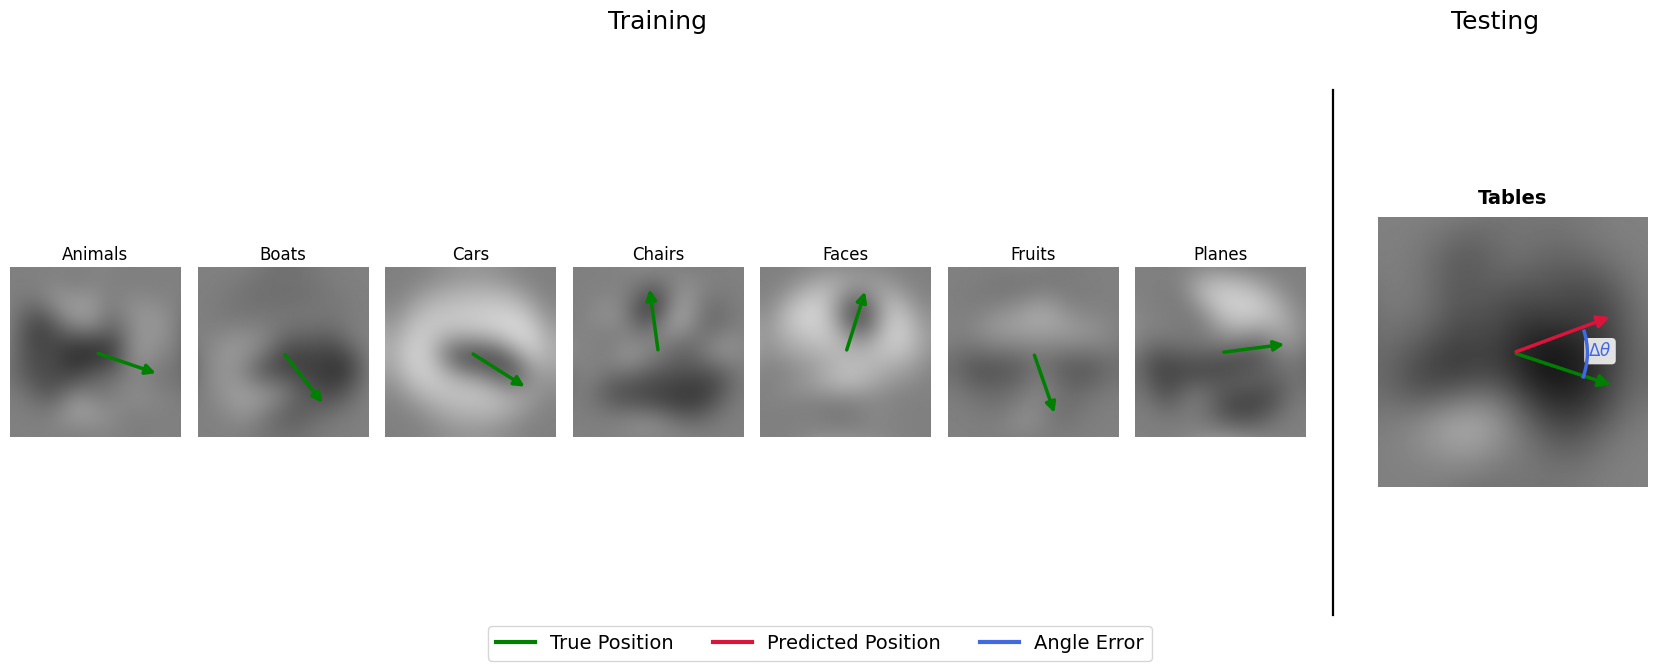

In [4]:
import io
import zipfile
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Arc
from matplotlib.lines import Line2D
from PIL import Image, ImageOps
from matplotlib import rcParams
from fractions import Fraction

# --- Configuration ---
DOWNLOAD_DIR = Path("downloads")
FIG_DIR = Path("Figures")
META_CSV = DOWNLOAD_DIR / "hvm_public_extended_meta.csv"
ZIP_HIGH = DOWNLOAD_DIR / "high_variation_stimuli.zip"
FOV_DEG = 8.0  # Field-of-view for Gaussian filter

FIG_DIR.mkdir(parents=True, exist_ok=True)
DOWNLOAD_DIR.mkdir(parents=True, exist_ok=True)

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

# --- IO and Image Helpers ---
def open_zip(zip_path: Path) -> zipfile.ZipFile:
    if not zip_path.exists():
        print(f"Warning: ZIP file not found at {zip_path}. Using placeholder images.")
        return None
    return zipfile.ZipFile(zip_path, "r")

def load_meta_high_variation(meta_csv: Path) -> pd.DataFrame:
    if not meta_csv.exists():
        raise FileNotFoundError(f"Missing metadata file: {meta_csv}")
    meta = pd.read_csv(meta_csv)
    meta["base"] = meta["filename"].str.replace(r"\.\w+$", "", regex=True)
    # NOTE: metadata stores centroid_x / centroid_y; code below uses (row, col)=(y, x)
    return meta.iloc[np.arange(640, len(meta))].reset_index(drop=True)

def load_grayscale_from_zip(zf: zipfile.ZipFile, base_stem: str):
    if zf is None: return None
    resize_dim = (256, 256)
    target = f"{base_stem}.png"
    for name in zf.namelist():
        if name.endswith(target):
            with zf.open(name) as fh:
                im = Image.open(io.BytesIO(fh.read())).convert("L")
                im = im.resize(resize_dim, Image.Resampling.LANCZOS)
                return np.asarray(im)
    return None

def get_representative_blurred_images(df: pd.DataFrame, zf: zipfile.ZipFile, categories: list):
    """Fetches a representative image, blurs it, and gets its centroid (row, col) = (y, x)."""
    data = {}
    for cat in categories:
        row = df[df["category_name"] == cat].iloc[0]
        base = row["base"]
        # Store as (row, col) i.e. (y, x) for image indexing
        centroid_rc = (row["centroid_y"], row["centroid_x"])
        original_img = load_grayscale_from_zip(zf, base)

        if original_img is None:
            blurred_img = np.full((256, 256), 128, dtype=np.uint8)
            centroid_rc = (128, 128)
        else:
            # Assumes you have this function in your workspace
            blurred_img = m_pathway_filter_gaussian(original_img, fov_deg=FOV_DEG)

        data[cat] = {"image": blurred_img, "centroid": centroid_rc}
    return data

# --- Angle utilities ---
def angle_deg_from_center_image_coords(point_rc, center_rc=(128, 128)):
    """
    Angle in degrees from center to point, using standard cartesian convention.
    Image has (row, col) with y down, so invert vertical.
    """
    r, c = point_rc
    cr, cc = center_rc
    dx = c - cc
    dy = cr - r  # invert sign for image coords
    return np.degrees(np.arctan2(dy, dx)) % 360.0

def minor_signed_delta(a_deg, b_deg):
    """Signed smallest difference b - a in degrees, in (-180, 180]."""
    return ((b_deg - a_deg + 180) % 360) - 180

def polar_to_image_xy(angle_deg, radius, center_rc=(128, 128)):
    """Polar (deg, radius) → image coords (x=col, y=row) with y-down."""
    cr, cc = center_rc
    rad = np.radians(angle_deg)
    x = cc + radius * np.cos(rad)
    y = cr - radius * np.sin(rad)
    return x, y



# --- Plotting Helpers ---
def plot_training_image(ax, data, label):
    ax.imshow(data["image"], cmap='gray', vmin=0, vmax=255)
    ax.axis('off')
    centroid = data["centroid"]  # (row, col)
    vec = np.array(centroid) - np.array([128, 128])
    nrm = np.linalg.norm(vec)
    dir_vec = vec / nrm if nrm > 0 else np.array([0, 0])
    end = np.array([128, 128]) + dir_vec * 100

    ax.add_patch(FancyArrowPatch((128, 128), end,
                                 arrowstyle='-|>', mutation_scale=15, lw=2.5, color='green'))
    ax.set_title(label, fontsize=12, pad=5)

def plot_test_image(ax, data, label):
    ax.imshow(data["image"], cmap='gray', vmin=0, vmax=255)
    ax.axis('off')
    for spine in ax.spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(2.5)
        spine.set_visible(True)

    center = (128, 128)

    # ---- Arrows (unchanged) ----
    true_rc = data["centroid"]  # (row, col)
    vec_t = np.array(true_rc) - np.array(center)
    n_t = np.linalg.norm(vec_t)
    dir_t = vec_t / n_t if n_t > 0 else np.array([0, 0])
    end_t = np.array(center) + dir_t * 100

    # Simulated predicted centroid (example)
    pred_rc_sim = (true_rc[0] + 20, true_rc[1] - 30)
    vec_p = np.array(pred_rc_sim) - np.array(center)
    n_p = np.linalg.norm(vec_p)
    dir_p = vec_p / n_p if n_p > 0 else np.array([0, 0])
    end_p = np.array(center) + dir_p * 100

    ax.add_patch(FancyArrowPatch(center, end_t, arrowstyle='-|>', mutation_scale=18, lw=2.5, color='green'))
    ax.add_patch(FancyArrowPatch(center, end_p, arrowstyle='-|>', mutation_scale=18, lw=2.5, color='crimson'))


    true_swapped_rc = (true_rc[1], true_rc[0])
    pred_swapped_rc = (pred_rc_sim[1], pred_rc_sim[0])

    theta_true = angle_deg_from_center_image_coords(true_swapped_rc, center)
    theta_pred = angle_deg_from_center_image_coords(pred_swapped_rc, center)
    dtheta = minor_signed_delta(theta_true, theta_pred)
    theta2 = theta_true + dtheta
    theta1_draw, theta2_draw = (theta_true, theta2) if dtheta >= 0 else (theta2, theta_true)

    arc_radius = 70
    arc = Arc((center[1], center[0]),
              width=2*arc_radius, height=2*arc_radius,
              angle=0, theta1=theta1_draw, theta2=theta2_draw,
              lw=2.5, color='royalblue', zorder=5)
    ax.add_patch(arc)

    # Label as a fraction of π
    mid_angle = (theta1_draw + theta2_draw) / 2.0
    tx, ty = polar_to_image_xy(mid_angle, arc_radius + 12, center)
    ax.text(tx, ty, rf"$\Delta\theta$",
            fontsize=12, color='royalblue', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='none', alpha=0.85))

    ax.set_title(label, fontsize=14, pad=10, weight='bold')

# --- Main Script ---
meta_hv = load_meta_high_variation(META_CSV)
zip_file = open_zip(ZIP_HIGH)
categories = sorted(meta_hv["category_name"].unique())

train_cats, test_cat = categories[:7], categories[7]
train_data = get_representative_blurred_images(meta_hv, zip_file, train_cats)
test_data = get_representative_blurred_images(meta_hv, zip_file, [test_cat])
if zip_file: zip_file.close()

fig = plt.figure(figsize=(18, 7))
L, R, B, T = 0.05, 0.98, 0.1, 0.85
xsplit = L + 0.72
fig.add_artist(Line2D([xsplit + 0.015, xsplit + 0.015], [B, T], lw=1.6, color="black", zorder=5))

fig.text((L + xsplit)/2, T + 0.08, "Training", ha="center", va="bottom", fontsize=18)
fig.text((xsplit + R)/2, T + 0.08, "Testing",  ha="center", va="bottom", fontsize=18)

grid_spec_train = fig.add_gridspec(1, 7, left=L, right=xsplit, bottom=B, top=T, wspace=0.1)
for i, cat in enumerate(train_cats):
    ax = fig.add_subplot(grid_spec_train[0, i])
    plot_training_image(ax, train_data[cat], cat)

grid_spec_test = fig.add_gridspec(1, 1, left=xsplit + 0.04, right=R - 0.02, bottom=B, top=T)
ax_test = fig.add_subplot(grid_spec_test[0, 0])
plot_test_image(ax_test, test_data[test_cat], f"{test_cat}")

legend_elements = [
    Line2D([0], [0], color='green',   lw=3, label='True Position'),
    Line2D([0], [0], color='crimson', lw=3, label='Predicted Position'),
    Line2D([0], [0], color='royalblue', lw=3, label='Angle Error')
]
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=3, fontsize=14)

out_png = FIG_DIR / "illustration_position_decoding_blurred.png"
out_svg = FIG_DIR / "illustration_position_decoding_blurred.svg"
out_pdf = FIG_DIR / "illustration_position_decoding_blurred.pdf"
fig.savefig(out_pdf, dpi=300)
fig.savefig(out_png, dpi=200, bbox_inches="tight")
fig.savefig(out_svg, bbox_inches="tight")
plt.show()

# Object-generalizing category information

## Illustration of methodology

Saved:
  Figures/method_LOO_train_test_grid_generalisation_LSF.png 
  Figures/method_LOO_train_test_grid_generalisation_LSF.svg


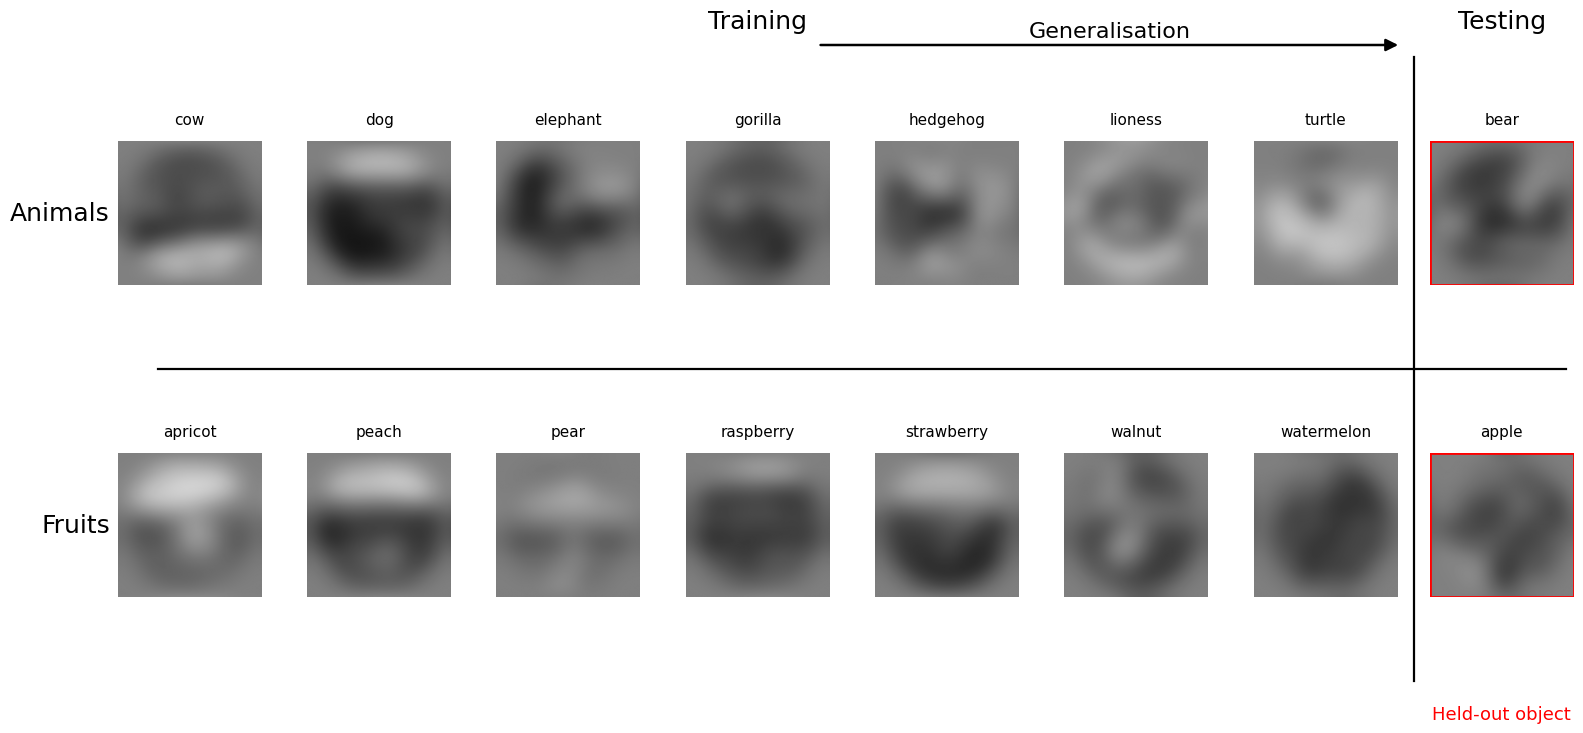

In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# Generalisation panel (LSF-blurred): leave-one-object-per-category out
# ─────────────────────────────────────────────────────────────────────────────

import io, zipfile, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Rectangle
from matplotlib.lines import Line2D
from PIL import Image, ImageOps

plt.rcParams.update({"svg.fonttype": "none"})  # keep text as text in SVG

# ------------------------- Config -------------------------
DOWNLOAD_DIR = Path("downloads")
FIG_DIR      = Path("Figures")
META_CSV     = DOWNLOAD_DIR / "hvm_public_extended_meta.csv"
ZIP_HIGH     = DOWNLOAD_DIR / "high_variation_stimuli.zip"

CAT1, CAT2 = "Animals", "Fruits"
HOLDOUT1, HOLDOUT2 = None, None

THUMB_SIZE      = (140, 140)
MIN_TRAIN_COLS  = 6
FIGSIZE         = (16, 8)

# LSF filter params
FOV_DEG         = 8.0
CUTOFF_CPD      = 0.5
ATTEN_DB_ATCUT  = -20

# ------------------------- IO helpers -------------------------
def open_zip(zip_path: Path) -> zipfile.ZipFile:
    if not zip_path.exists():
        raise FileNotFoundError(f"Missing archive: {zip_path}")
    return zipfile.ZipFile(zip_path, "r")

def load_meta_high_variation(meta_csv: Path) -> pd.DataFrame:
    meta = pd.read_csv(meta_csv)
    meta["base"] = meta["filename"].str.replace(r"\.\w+$", "", regex=True)
    # Keep high-variation subset (skip first 640 background-only rows)
    return meta.iloc[np.arange(640, len(meta))].reset_index(drop=True)

def load_grayscale_from_zip(zf: zipfile.ZipFile, base_stem: str, resize=THUMB_SIZE):
    target = f"{base_stem}.png"
    for name in zf.namelist():
        if name.endswith(target):
            with zf.open(name) as fh:
                im = Image.open(io.BytesIO(fh.read())).convert("L")
                im = ImageOps.contain(im, resize)
                return np.asarray(im)
    return None

def representative_blurred(df_subset: pd.DataFrame, category: str, object_name: str, zf: zipfile.ZipFile):
    rows = df_subset.query("category_name == @category and object_name == @object_name")
    if rows.empty:
        return None
    base = rows.iloc[0]["base"]
    arr  = load_grayscale_from_zip(zf, base, resize=THUMB_SIZE)
    if arr is None:
        return None
    lp   = m_pathway_filter_gaussian(arr.astype(float),
                                     cutoff_cpd=CUTOFF_CPD,
                                     fov_deg=FOV_DEG,
                                     atten_dB_at_cut=ATTEN_DB_ATCUT)
    return np.clip(lp, 0, 255).astype(np.uint8)

# ---------------------- Build split & images -----------------------
meta_hv = load_meta_high_variation(META_CSV)
with open_zip(ZIP_HIGH) as zf:
    avail = meta_hv["category_name"].unique().tolist()
    if CAT1 not in avail or CAT2 not in avail:
        raise ValueError(f"Categories must be among {avail}, got ({CAT1}, {CAT2}).")

    objs1 = sorted(meta_hv.query("category_name == @CAT1")["object_name"].unique())
    objs2 = sorted(meta_hv.query("category_name == @CAT2")["object_name"].unique())
    if HOLDOUT1 is None: HOLDOUT1 = objs1[0]
    if HOLDOUT2 is None: HOLDOUT2 = objs2[0]
    if HOLDOUT1 not in objs1: raise ValueError(f"holdout1 '{HOLDOUT1}' not in {objs1}")
    if HOLDOUT2 not in objs2: raise ValueError(f"holdout2 '{HOLDOUT2}' not in {objs2}")

    pair_mask = meta_hv["category_name"].isin([CAT1, CAT2])
    df_pair   = meta_hv[pair_mask].copy()
    is_test   = ((df_pair["category_name"] == CAT1) & (df_pair["object_name"] == HOLDOUT1)) | \
                ((df_pair["category_name"] == CAT2) & (df_pair["object_name"] == HOLDOUT2))
    df_test, df_train = df_pair[is_test], df_pair[~is_test]

    train_imgs_c1 = {}
    for o in objs1:
        if o == HOLDOUT1: continue
        im = representative_blurred(df_train, CAT1, o, zf)
        if im is not None: train_imgs_c1[o] = im

    train_imgs_c2 = {}
    for o in objs2:
        if o == HOLDOUT2: continue
        im = representative_blurred(df_train, CAT2, o, zf)
        if im is not None: train_imgs_c2[o] = im

    test_img_c1 = {}
    im = representative_blurred(df_test, CAT1, HOLDOUT1, zf)
    if im is not None: test_img_c1[HOLDOUT1] = im

    test_img_c2 = {}
    im = representative_blurred(df_test, CAT2, HOLDOUT2, zf)
    if im is not None: test_img_c2[HOLDOUT2] = im

# ----------------------------- Plot helpers ------------------------
def label_above(fig, x_center, y_top, text, fontsize=11, pad=0.008):
    """Place a label above a thumbnail using figure coordinates."""
    fig.text(x_center, y_top + pad, text, ha="center", va="bottom", fontsize=fontsize)

def place_training_row(fig, images_dict, band_bottom, band_top,
                       area_left, area_right, min_cols=MIN_TRAIN_COLS,
                       box_w=0.09, box_h=0.20):
    """Place thumbnails within a horizontal band [band_bottom, band_top] (figure coords)."""
    keys = sorted(images_dict.keys())
    if not keys: return
    # keep a safety pad so images do not touch the separation line
    vpad = 0.015
    y_center = (band_bottom + band_top) / 2.0
    box_h = min(box_h, (band_top - band_bottom) - 2*vpad)
    y0 = y_center - box_h/2.0

    n = len(keys)
    cols = max(min_cols, n)
    xs_all = np.linspace(area_left + 0.02, area_right - 0.02, cols)
    if n < cols:
        start = (cols - n)//2
        xs = xs_all[start:start+n]
    else:
        xs = np.linspace(area_left + 0.02, area_right - 0.02, n)

    for x, k in zip(xs, keys):
        x0 = x - box_w/2.0
        ax = fig.add_axes([x0, y0, box_w, box_h])
        ax.imshow(images_dict[k], cmap="gray", vmin=0, vmax=255)
        ax.set_axis_off()
        label_above(fig, x, y0 + box_h, k, fontsize=11)

def place_test_single(fig, image_dict, x_center, band_bottom, band_top,
                      box_w=0.09, box_h=0.20):
    if not image_dict: return
    vpad = 0.015
    y_center = (band_bottom + band_top) / 2.0
    box_h = min(box_h, (band_top - band_bottom) - 2*vpad)
    y0 = y_center - box_h/2.0

    (name, im), = image_dict.items()
    ax = fig.add_axes([x_center - box_w/2.0, y0, box_w, box_h])
    ax.imshow(im, cmap="gray", vmin=0, vmax=255)
    ax.set_axis_off()
    label_above(fig, x_center, y0 + box_h, name, fontsize=11)
    ax.add_patch(Rectangle((0,0),1,1, transform=ax.transAxes,
                           lw=2, edgecolor="red", facecolor="none"))

# ----------------------------- Plot -------------------------------
fig = plt.figure(figsize=FIGSIZE)

# Full-figure coordinates
L, R = 0.10, 0.98
B, T = 0.12, 0.90

left_w, right_w = 0.75, 0.18
xsplit = L + left_w
mid    = (T + B) / 2.0

# Draw separation lines in FIGURE COORDINATES (no overlap issues)
fig.add_artist(Line2D([L, R], [mid, mid], lw=1.6, color="black", zorder=5, transform=fig.transFigure))
fig.add_artist(Line2D([xsplit +.035, xsplit +.035], [B, T], lw=1.6, color="black", zorder=5, transform=fig.transFigure))

# Headers (figure coords)
fig.text(L + left_w/2.0, T + 0.03, "Training", ha="center", va="bottom", fontsize=18)
fig.text(xsplit + right_w/2.0, T + 0.03, "Testing",  ha="center", va="bottom", fontsize=18)

# Arrow + label (figure coords)
xs, xe = L + left_w*0.55, xsplit + right_w*0.15
fig.patches.append(FancyArrowPatch((xs, T + 0.015), (xe, T + 0.015),
                                   arrowstyle='-|>', mutation_scale=18, lw=1.8,
                                   color="black", transform=fig.transFigure))
fig.text((xs + xe)/2.0, T + 0.02, "Generalisation", ha="center", va="bottom", fontsize=16)

# Category labels (figure coords)
fig.text(L - 0.03, (T + mid)/2.0, CAT1, ha="right", va="center", fontsize=18)
fig.text(L - 0.03, (mid + B)/2.0, CAT2, ha="right",  va="center", fontsize=18)

# Training rows (blurred thumbnails) — use bands with padding to avoid the mid line
place_training_row(fig, train_imgs_c1, band_bottom=mid+0.02, band_top=T-0.02,
                   area_left=L, area_right=xsplit, min_cols=MIN_TRAIN_COLS)
place_training_row(fig, train_imgs_c2, band_bottom=B+0.02,  band_top=mid-0.02,
                   area_left=L, area_right=xsplit, min_cols=MIN_TRAIN_COLS)

# Test column (blurred held-out)
x_center = xsplit + right_w/2.0
place_test_single(fig, test_img_c1, x_center=x_center,
                  band_bottom=mid+0.02, band_top=T-0.02)
place_test_single(fig, test_img_c2, x_center=x_center,
                  band_bottom=B+0.02,  band_top=mid-0.02)

# Legend
fig.text(x_center, B - 0.03, "Held-out object", ha="center", va="top", fontsize=13, color="red")

FIG_DIR.mkdir(parents=True, exist_ok=True)
out_png = FIG_DIR / "method_LOO_train_test_grid_generalisation_LSF.png"
out_svg = FIG_DIR / "method_LOO_train_test_grid_generalisation_LSF.svg"
fig.savefig(out_png, dpi=200, bbox_inches="tight")
fig.savefig(out_svg, bbox_inches="tight")
print("Saved:\n ", out_png, "\n ", out_svg)

# Distance to object prototype

## Illustration of hypothesis

Figure saved to Figures/schema_images_generated.pdf


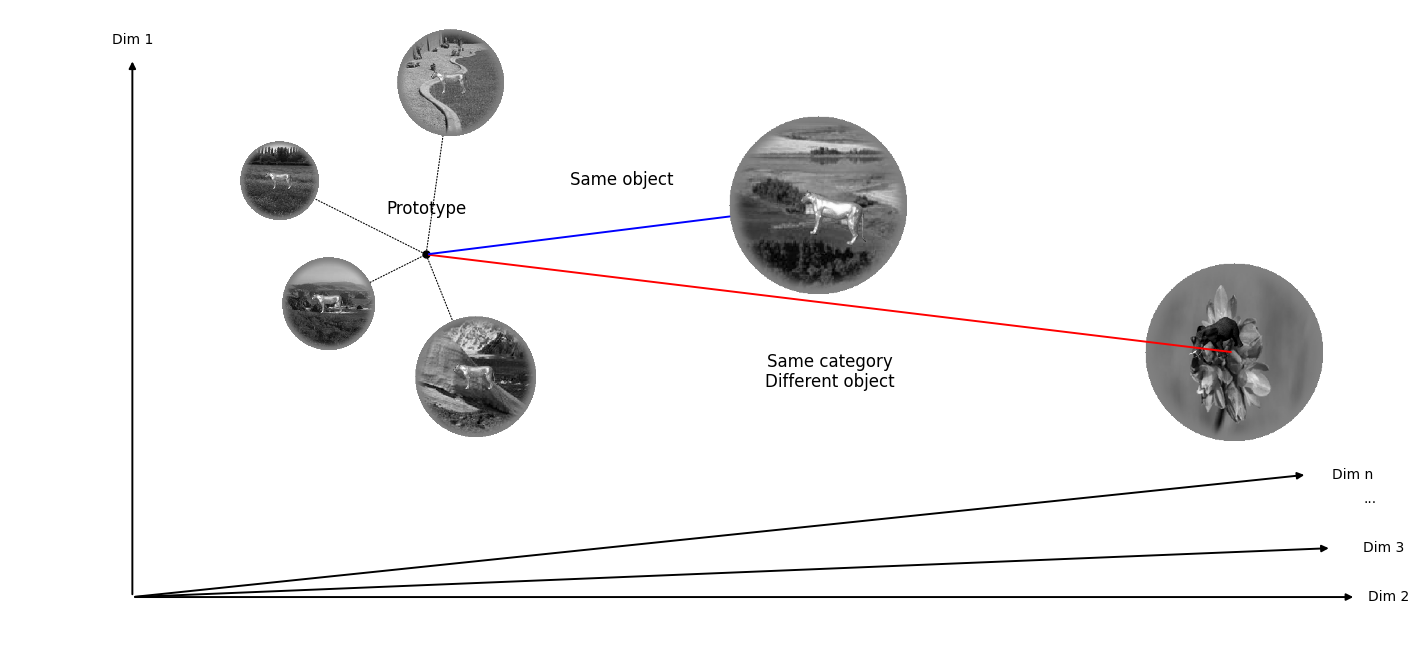

In [6]:
CATEGORY        = "animal"      # one of meta.category_name
OBJ_MAIN        = "lioness"      # object shown in LOW + HIGH-same-object
OBJ_OTHER       = "elephant"     # another object from the same category

# 2-D coordinates (Dim-1 vs Dim-50 plane, arbitrary units)
PROTOTYPE_PT    = (1.2, 1.4)
LOW_COORDS      = [(0.6, 1.70), (1.3, 2.1), (0.8, 1.20), (1.4, .9)]
HIGH_SAME_COORD = (2.8, 1.60)
HIGH_DIFF_COORD = (4.5, 1)

# Relative image size
LOW_ZOOMS        = (0.22, .3, 0.26, 0.34)
HIGH_ZOOMS       = (.5, 0.5)

# Data file names (change if yours differ)
META_CSV        = "downloads/hvm_public_extended_meta.csv"
ZIP_LOW         = "downloads/background_variations_images.zip"
ZIP_HIGH        = "downloads/high_variation_stimuli.zip"
OUT_FIG         = "Figures/schema_images_generated.pdf"

# How to treat pixels outside the circular aperture: "alpha" (transparent) or "white"
APERTURE_MODE   = "alpha"   # change to "white" if you prefer white background
APERTURE_RADIUS = 128       # images are 256x256, circle centered

# ======================================================================
import io, random, zipfile, os, sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import FancyBboxPatch
from PIL import Image
import numpy as np
np.random.seed(42)

# ---------- Helper: load PNG by SHA-1 inside a zip (search subfolders) --
def load_image_from_zip(zfile: zipfile.ZipFile, sha_png: str):
    for name in zfile.namelist():
        if name.endswith(sha_png):
            with zfile.open(name) as f:
                return Image.open(io.BytesIO(f.read()))
    return None

# ---------- Aperture processing: make outside-circle transparent/white ------
def apply_circular_aperture(img: Image.Image,
                            radius: int = APERTURE_RADIUS,
                            mode: str = APERTURE_MODE) -> Image.Image:
    """
    Ensures RGBA and sets alpha=0 (or RGB=255) for pixels outside a centered circle.
    Assumes square 256x256, but works for any square image by using min dimension.
    """
    img = img.convert("RGBA")
    arr = np.array(img)
    h, w = arr.shape[:2]
    cx, cy = w // 2, h // 2
    r = min(radius, cx, cy)

    # boolean mask for pixels INSIDE the circle
    yy, xx = np.ogrid[:h, :w]
    inside = (xx - cx) ** 2 + (yy - cy) ** 2 <= r * r

    if mode.lower() == "alpha":
        # punch out: transparent outside
        arr[~inside, 3] = 0
    else:
        # white outside, keep alpha=255
        arr[~inside, :3] = 255
        arr[~inside, 3] = 255

    return Image.fromarray(arr)

# ---------- Load metadata & archives -----------------------------------
if not os.path.exists(META_CSV):
    sys.exit(f"Metadata file '{META_CSV}' not found.")
meta = pd.read_csv(META_CSV)

try:
    zip_low  = zipfile.ZipFile(ZIP_LOW)
    zip_high = zipfile.ZipFile(ZIP_HIGH)
except FileNotFoundError as e:
    sys.exit(e)

# Helper to embed image
def add_image(img, xy, zoom):
    if img is None:
        rect = FancyBboxPatch((xy[0]-0.14, xy[1]-0.14), 0.28, 0.28,
                              boxstyle="round,pad=0.02", edgecolor='red', facecolor='white')
        ax.add_patch(rect)
        ax.text(*xy, "MISSING", ha='center', va='center', fontsize=6)
        return
    # Matplotlib can take a PIL image; keep frame off to respect alpha
    ab = AnnotationBbox(OffsetImage(img, zoom=zoom), xy, frameon=False, pad=0)
    ax.add_artist(ab)

# ---------- Pick exemplar filenames ------------------------------------
def pick_images(obj_name, variation, k):
    rows = meta[(meta.object_name == obj_name) & (meta.variation == variation)]
    if len(rows) < k:
        sys.exit(f"Not enough images for '{obj_name}', variation {variation}")
    return random.sample(rows["filename"].tolist(), k)

sha_low  = pick_images(OBJ_MAIN, 0, 4)       # four low-variation
sha_same = pick_images(OBJ_MAIN, 3, 1)[0]    # same object, high-variation
sha_diff = pick_images(OBJ_OTHER, 3, 1)[0]   # diff object, high-variation

# ---------- Load PIL images + apply aperture ---------------------------
def get_img(sha1):
    im = (load_image_from_zip(zip_low,  sha1)
          or load_image_from_zip(zip_high, sha1))
    if im is None:
        return None
    return apply_circular_aperture(im)

img_low   = [get_img(s) for s in sha_low]
img_same  = get_img(sha_same)
img_diff  = get_img(sha_diff)

# ---------- Build figure -----------------------------------------------
fig, ax = plt.subplots(figsize=(18, 10))
ax.set_aspect('equal')
ax.set_xlim(-0.5, 5.2)
ax.set_ylim(-0.2, 2.4)
ax.axis('off')

# Axes arrows
ax.annotate("", xy=(0.0, 2.2), xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.4, color='black'))
ax.text(0, 2.25, "Dim 1", va='bottom', ha='center')

ax.annotate("", xy=(5.0, 0.0), xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.4, color='black'))
ax.text(5.05, 0, "Dim 2", va='center', ha='left')

ax.annotate("", xy=(4.9, .2), xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.4, color='black'))
ax.text(5.03, .2, "Dim 3", va='center', ha='left')

ax.text(5.03, .4, "...", va='center', ha='left')

ax.annotate("", xy=(4.8, .5), xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.4, color='black'))
ax.text(4.9, .5, "Dim n", va='center', ha='left')

# High-variation different object
mid_diff = ((PROTOTYPE_PT[0]+HIGH_DIFF_COORD[0])/2,
            (PROTOTYPE_PT[1]+HIGH_DIFF_COORD[1])/2)
add_image(img_diff, HIGH_DIFF_COORD, HIGH_ZOOMS[1])
ax.annotate("", xy=HIGH_DIFF_COORD, xytext=PROTOTYPE_PT,
            arrowprops=dict(arrowstyle='-', lw=1.4, color='r'))

# Prototype
ax.plot(*PROTOTYPE_PT, 'ko', markersize=5)
ax.text(PROTOTYPE_PT[0], PROTOTYPE_PT[1] + 0.15, "Prototype",
        ha='center', va='bottom', fontsize=12)

# Low-variation images (dotted connectors)
for coord, img, LOW_ZOOM in zip(LOW_COORDS, img_low, LOW_ZOOMS):
    ax.annotate("", xy=PROTOTYPE_PT, xytext=coord,
                arrowprops=dict(lw=0.8, linestyle='dotted',
                                arrowstyle='-', color='black'))
    add_image(img, coord, LOW_ZOOM)

# High-variation same object
ax.annotate("", xy=HIGH_SAME_COORD, xytext=PROTOTYPE_PT,
            arrowprops=dict(arrowstyle='-', lw=1.4, color='b'))
mid_same = ((PROTOTYPE_PT[0]+HIGH_SAME_COORD[0])/2,
            (PROTOTYPE_PT[1]+HIGH_SAME_COORD[1])/2)
add_image(img_same, HIGH_SAME_COORD, HIGH_ZOOMS[0])
ax.text(mid_same[0], mid_same[1]+0.17, "Same object",
        ha='center', va='bottom', fontsize=12)

ax.text(mid_diff[0], mid_diff[1]-0.20,
        "Same category\nDifferent object", ha='center', va='top', fontsize=12)

# ---------- Save --------------------------------------------------------
fig.savefig(OUT_FIG, dpi=600, bbox_inches='tight')
print("Figure saved to", OUT_FIG)